# 1 UCI Performance
This notebook summarizes the performance and analysis on the  UCI Datasets.

In [1]:

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sciplotlib import style
import seaborn as sns

from myst_nb import glue


from leakconfound.plotting import custom_bar_rope_plot, mm_to_inch
from leakconfound.plotting.settings import red, blue, green
from leakconfound.analyses.load import (
    prepare_performance_data, gather_data, data_to_long, data_renamer, models_renamer)

## Set MPL Settings

In [2]:

mpl.style.use(style.get_style('nature-reviews'))
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('axes', labelsize=12, titlesize=12)
mpl.rc('figure', dpi=300)
mpl.rc('figure.subplot', wspace=mm_to_inch(4), hspace=mm_to_inch(7))
mpl.rc('lines', linewidth=1)

Load Datasets

In [3]:
results_base = '../../results/'
raw_TaCo_folder = f'{results_base}basic_TaCo/uci_datasets/'
shuffled_TaCo_folder = results_base + 'shuffled_features_TaCo/uci_datasets/'

# load raw TaCo dataset
arguments_TaCo = ['data', 'model_name',
                  'is_deconfounded', 'random_seed']
score_names = [
    'test_r2', 'test_roc_auc',
    'test_X_hat_r2', 'test_X_hat_roc_auc',
]


def correct_fold_repeat(df):
    df.repeat = df.fold // 5
    df.fold = df.fold % 5
    return df


def convert_hat_scores(df):
    _df = df.copy()
    return (_df
            .assign(
                is_X_hat=lambda df: df.score_name.str.contains("X_hat")
            )
            .assign(
                confound=lambda df: df.apply(
                    lambda row: "X hat" if row["is_X_hat"] else row["confound"], axis=1
                ))
            .assign(
                score_name=lambda df: df.score_name.str.replace("X_hat_", "")

            )
            )


def correct_columns(df):
    return correct_fold_repeat(convert_hat_scores(df)).dropna()

Load Raw Data

In [4]:

df_TaCo = prepare_performance_data(raw_TaCo_folder,
                                   analysis_arguments=arguments_TaCo,
                                   score_names=score_names)

# load performance TaCo shuffled

df_TaCo_shuffled = prepare_performance_data(shuffled_TaCo_folder,
                                            analysis_arguments=arguments_TaCo,
                                            score_names=score_names).dropna()

arguments_TaCo.pop(2)
arguments_TaCo.extend(['confound'])

Subset TaCo data

In [5]:
order = ["Linear/Logistic", "Decision Tree",
         "Random Forest", "Neural Network",
         "Linear SVM", "RBF SVM", "Gaussian Model"]

datasets_selected = ["Abalone", "Heart", "Real Estate", "Blood"]

df_plot_TaCo_selected = (df_TaCo
                         .dropna()
                         .query('data in @datasets_selected')
                         .query(f'model_name in {order}')
                         .query(f"score_name in {score_names}")
                         )


df_plot_TaCo_shuffled_selected = (df_TaCo_shuffled
                                  .query('data in @datasets_selected')
                                  .query(f'model_name in {order}')
                                  .query(f"score_name in {score_names}")
                                  )


Data Retrieval non TaCo -> simulated confounds

In [6]:
def prepare_non_TaCo(shuffled):

    used_model = 'Random Forest'
    non_TaCo_folder = results_base + (
        '/shuffled_features_non_TaCo/uci_sim_conf_datasets/' if shuffled
        else '/basic_non_TaCo/uci_sim_conf_datasets/'
    )

    non_TaCo_arguments = ['data', 'model_name',
                          'is_deconfounded', 'random_seed']

    df_non_TaCo = gather_data(non_TaCo_folder,
                              non_TaCo_arguments,
                              )

    non_TaCo_arguments.append('conf_corr')
    # adding how much correlation was used for the confounds
    df_settings = (
        df_non_TaCo
        .data
        .apply(lambda col: col.replace('real_estate', 'realestate'))
        .apply(lambda col: pd.Series(col.split('_')))
        .apply(lambda col: col.replace('realestate', 'real_estate'))
        .rename(columns={0: 'data', 2: 'conf_corr'})
        .drop(columns=[1])
    )

    df_non_TaCo = (
        pd.concat([df_non_TaCo.drop(columns='data'), df_settings], axis=1)
        .assign(
            data=lambda df: df.data.map(data_renamer),
            model_name=lambda df: df.model_name.map(models_renamer),
            conf_corr=lambda df: df.conf_corr.apply(lambda x: '0.' + str(x))
        )
    )

    df_plot_non_TaCo = (data_to_long(df_non_TaCo, non_TaCo_arguments,
                                     score_names)
                        .query(f'(model_name == "{used_model}") & '
                               f'(score_name in {score_names})'
                               )
                        .dropna()
                        )

    return df_plot_non_TaCo


df_plot_non_TaCo = prepare_non_TaCo(False)
df_plot_non_TaCo_shuffled = prepare_non_TaCo(True)

df_plot_non_TaCo_selected = (df_plot_non_TaCo
                             .dropna()
                             .query('data in @datasets_selected')
                             .query(f'model_name in {order}')
                             .query(f"score_name in {score_names}")
                             )


df_plot_non_TaCo_shuffled_selected = (df_plot_non_TaCo_shuffled
                                      .query('data in @datasets_selected')
                                      .query(f'model_name in {order}')
                                      .query(f"score_name in {score_names}")
                                      )

clean & correct Repeat and Fold & Scoring

In [7]:
df_plot_TaCo = correct_columns(df_TaCo)
df_plot_TaCo_shuffled = correct_columns(df_TaCo_shuffled)
df_plot_non_TaCo = correct_columns(df_plot_non_TaCo)
df_plot_non_TaCo_shuffled = correct_columns(df_plot_non_TaCo_shuffled)

df_plot_TaCo_selected = correct_columns(df_plot_TaCo_selected)
df_plot_TaCo_shuffled_selected = correct_columns(df_plot_TaCo_shuffled_selected)
df_plot_non_TaCo_selected = correct_columns(df_plot_non_TaCo_selected)
df_plot_non_TaCo_shuffled_selected = correct_columns(df_plot_non_TaCo_shuffled_selected)

Create a function to plot

In [8]:

def plot_performance(df_TaCo, df_non_TaCo, figsize=None, model_label_dict=None,
                     hue_order=None,
                     ):
    # col = 'features'
    row = 'data'
    x = 'model_name'
    y = 'score'
    hue = 'confound'
    hue_order = ['not removed', 'removed'] if hue_order is None else hue_order

    row_vals = df_TaCo[row].unique()
    n_rows = len(row_vals)
    rope_sign_fontsize = 9

    used_model_dict = ({
        'Linear/Logistic': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'Neural Network': 'MLP'
    } if model_label_dict is None else model_label_dict
    )

    ylabel_dict = {
        'test_roc_auc': 'AUROC',
        'test_r2': 'R²'
    }

    fig, axes = plt.subplots(
        nrows=n_rows, ncols=2, figsize=figsize)

    for (i_row, row_val) in enumerate(row_vals):  # ,
        # enumerate(col_vals)):
        ax = axes[i_row, 0]
        data = df_TaCo.query(
            '(score_name in ["test_r2", "test_roc_auc"] ) & '
            f'({row} == @row_val)'
        )
        score_names = data.score_name.unique()
        # assert len(score_names) == 1
        score_name = score_names[0]

        custom_bar_rope_plot(x, y, hue,
                             comparisons=(('X hat', 'not removed'), ('not removed', 'removed')),
                             comparisons_sing_y=[1.1, 1.15],
                             cv_repeats='repeat', data=data,
                             hue_order=hue_order,
                             order=list(used_model_dict.keys()),
                             palette=sns.color_palette([green, blue, red]),
                             ax=ax, show_legend=False,
                             rope_sign_fontsize=rope_sign_fontsize, rope_line_width=.5,
                             rope=0.05

                             )

        if i_row == 0:
            ax.set_title('TaCo CR',)
        if i_row < len(row_vals)-1:
            ax.set_xticklabels('', rotation=0)
            ax.set_xlabel('')

        else:
            ax.set_xticklabels(
                [used_model_dict[tick.get_text()] for tick in ax.get_xticklabels()], rotation=0,
            )
            ax.set_xlabel('Model Used', )
        ax.set_ylabel(ylabel_dict[score_name], )
        ax.set_yticks(np.arange(0, 1.25, .25))

        ax.set_ylim([-0.05, 1.2])

        ax.yaxis.set_major_locator(MultipleLocator(.5))

    for (i_row, row_val) in enumerate(row_vals):
        ax = axes[i_row, 1]

        data = df_non_TaCo.query(
            f'(model_name == "Random Forest") & ({row} == @row_val)')
        custom_bar_rope_plot('conf_corr', y, hue,
                             comparisons=(('X hat', 'not removed'), ('not removed', 'removed')),
                             comparisons_sing_y=[1.1, 1.15],
                             cv_repeats='repeat', data=data,
                             hue_order=hue_order,
                             order=['0.2', '0.4', '0.6', '0.8'],
                             palette=sns.color_palette([green, blue, red]),
                             rope_sign_fontsize=rope_sign_fontsize,
                             rope_line_width=.5,
                             ax=ax, show_legend=False,
                             rope=0.05

                             )
        if i_row == 0:
            ax.set_title('CR Simulated Confounds',)
        if i_row < len(row_vals)-1:
            ax.set_xticklabels('')
            ax.set_xlabel('')
        else:
            ax.set_xticklabels(ax.get_xticklabels(),
                               rotation=0)
            ax.set_xlabel('Confound Target \nCorrelation',)

        ax.set_ylim([-0.05, 1.2])

        axR = ax.twinx()
        axR.set_yticks([])
        axR.set_ylabel(row_val, rotation=270, labelpad=8,
                       horizontalalignment='center', verticalalignment='center'

                       )

        handles = [
            mpl.patches.Patch(color=green,  label=r'$\hat{X}$'),
            mpl.patches.Patch(color=blue,  label='$X$'),
            mpl.patches.Patch(color=red, label='$X_{CR}$')
        ]

        fig.legend(handles=handles,
                   title="Features:",
                   loc='upper center',
                   ncol=3,)

    return fig, axes

# Plotting Performance for Selected Datapoints

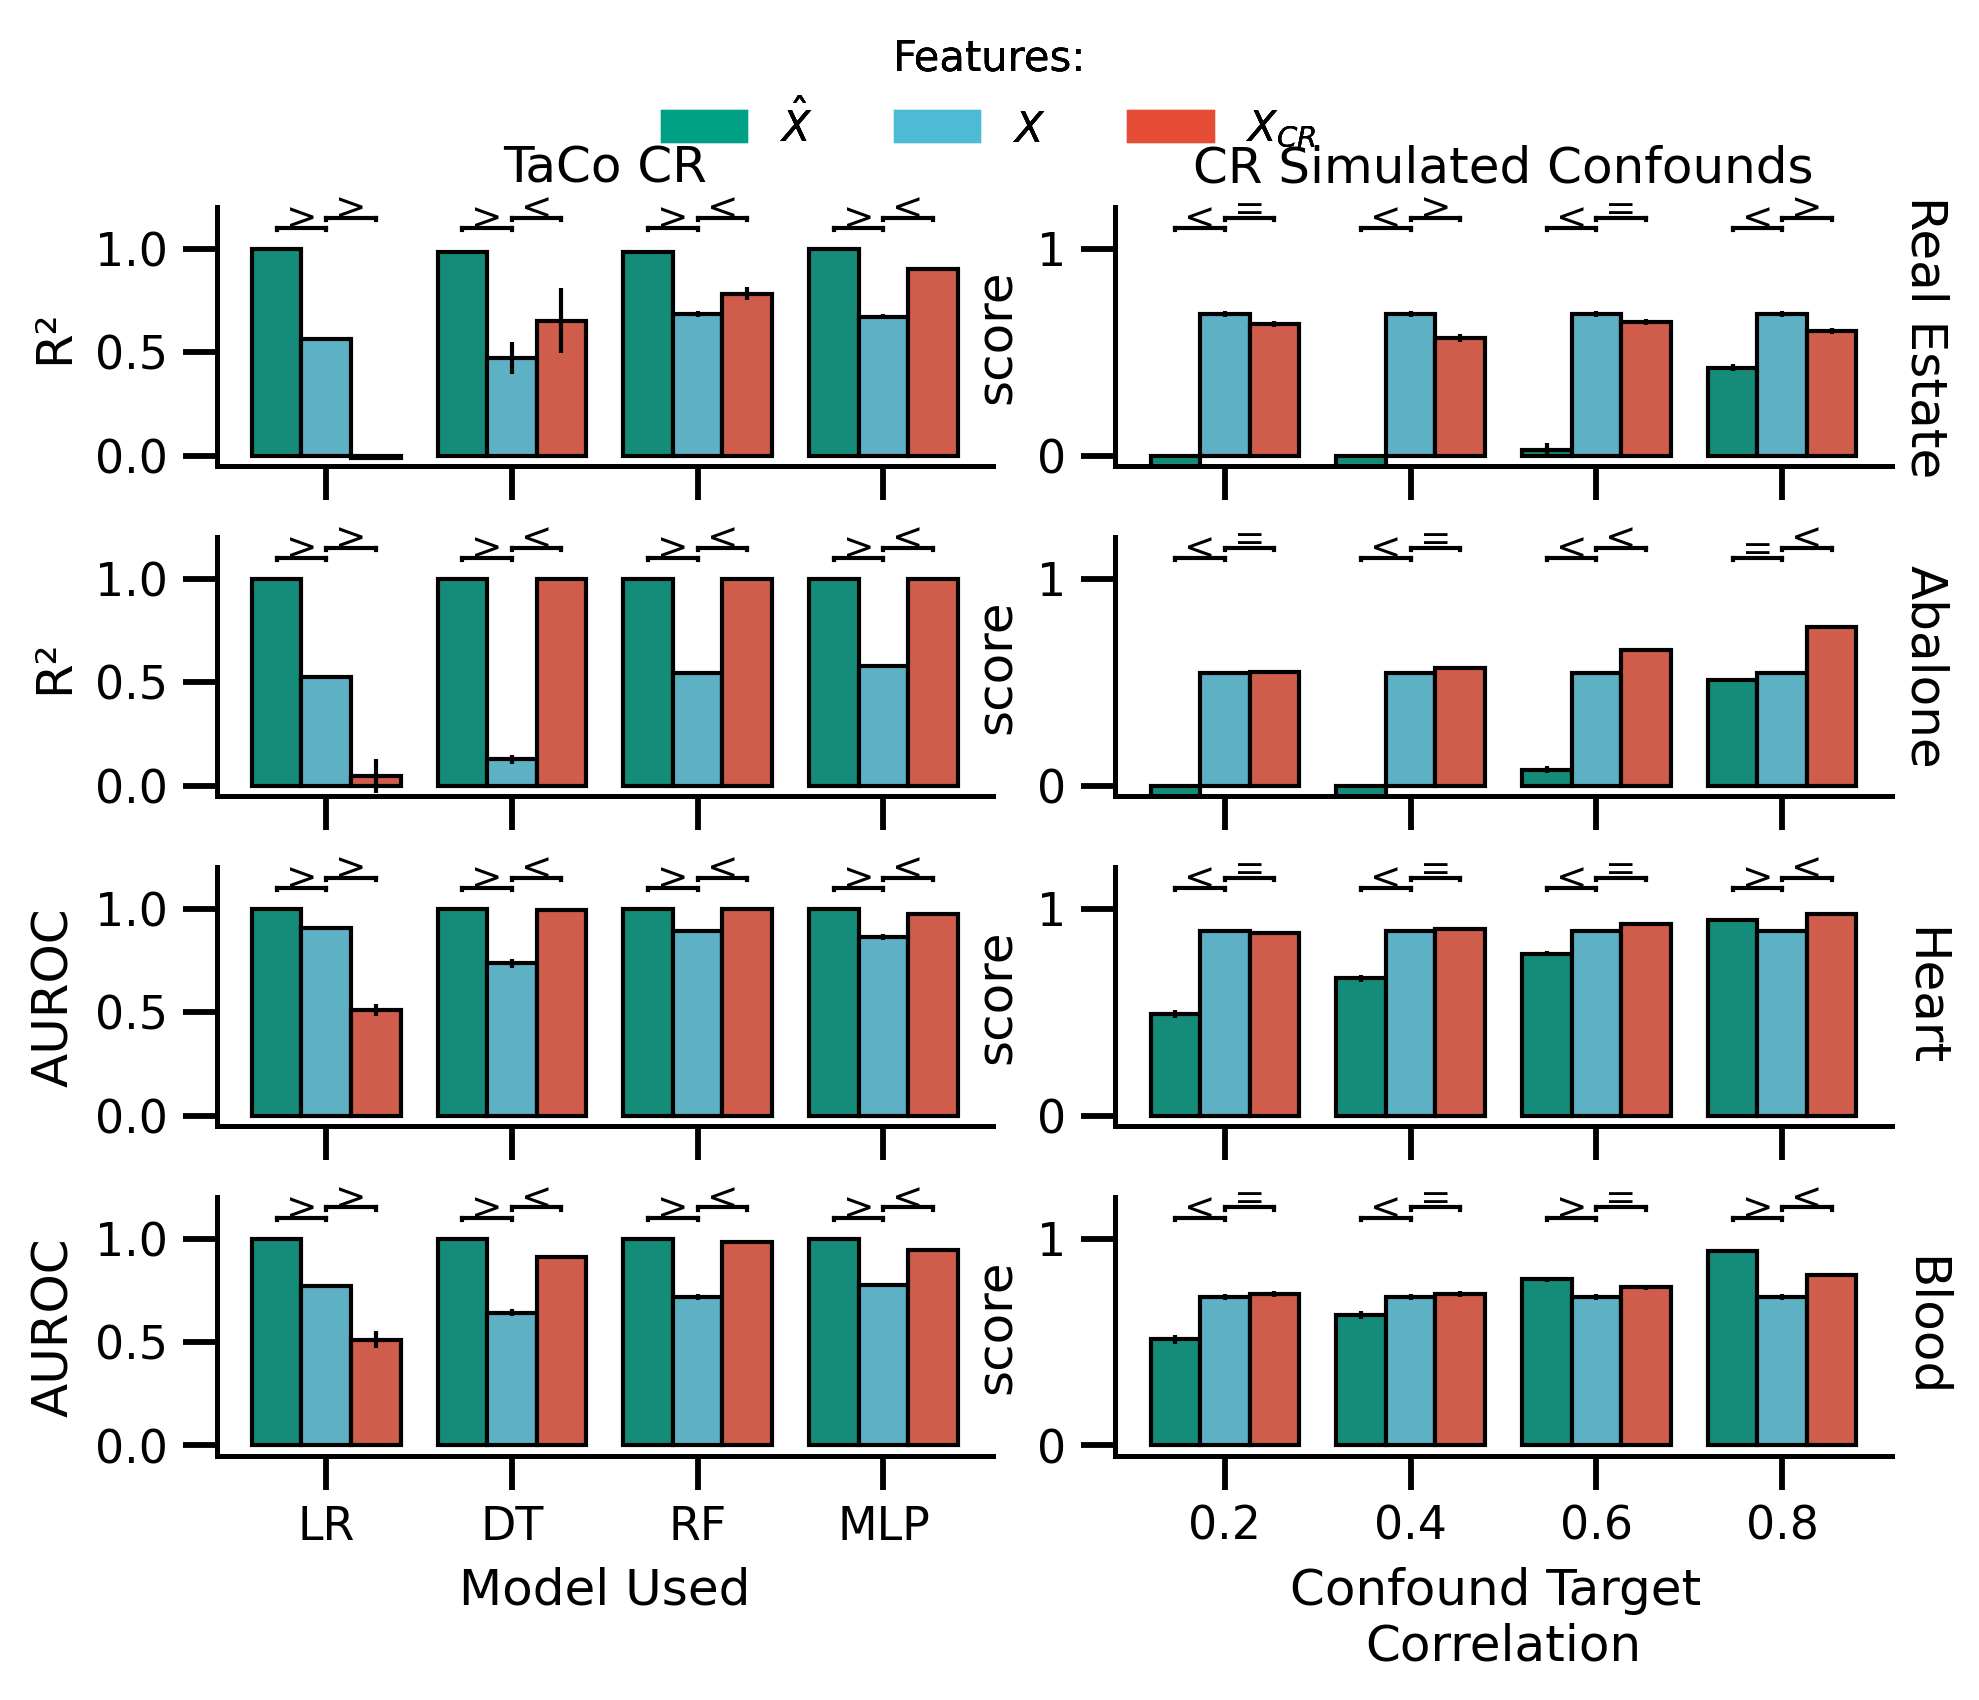

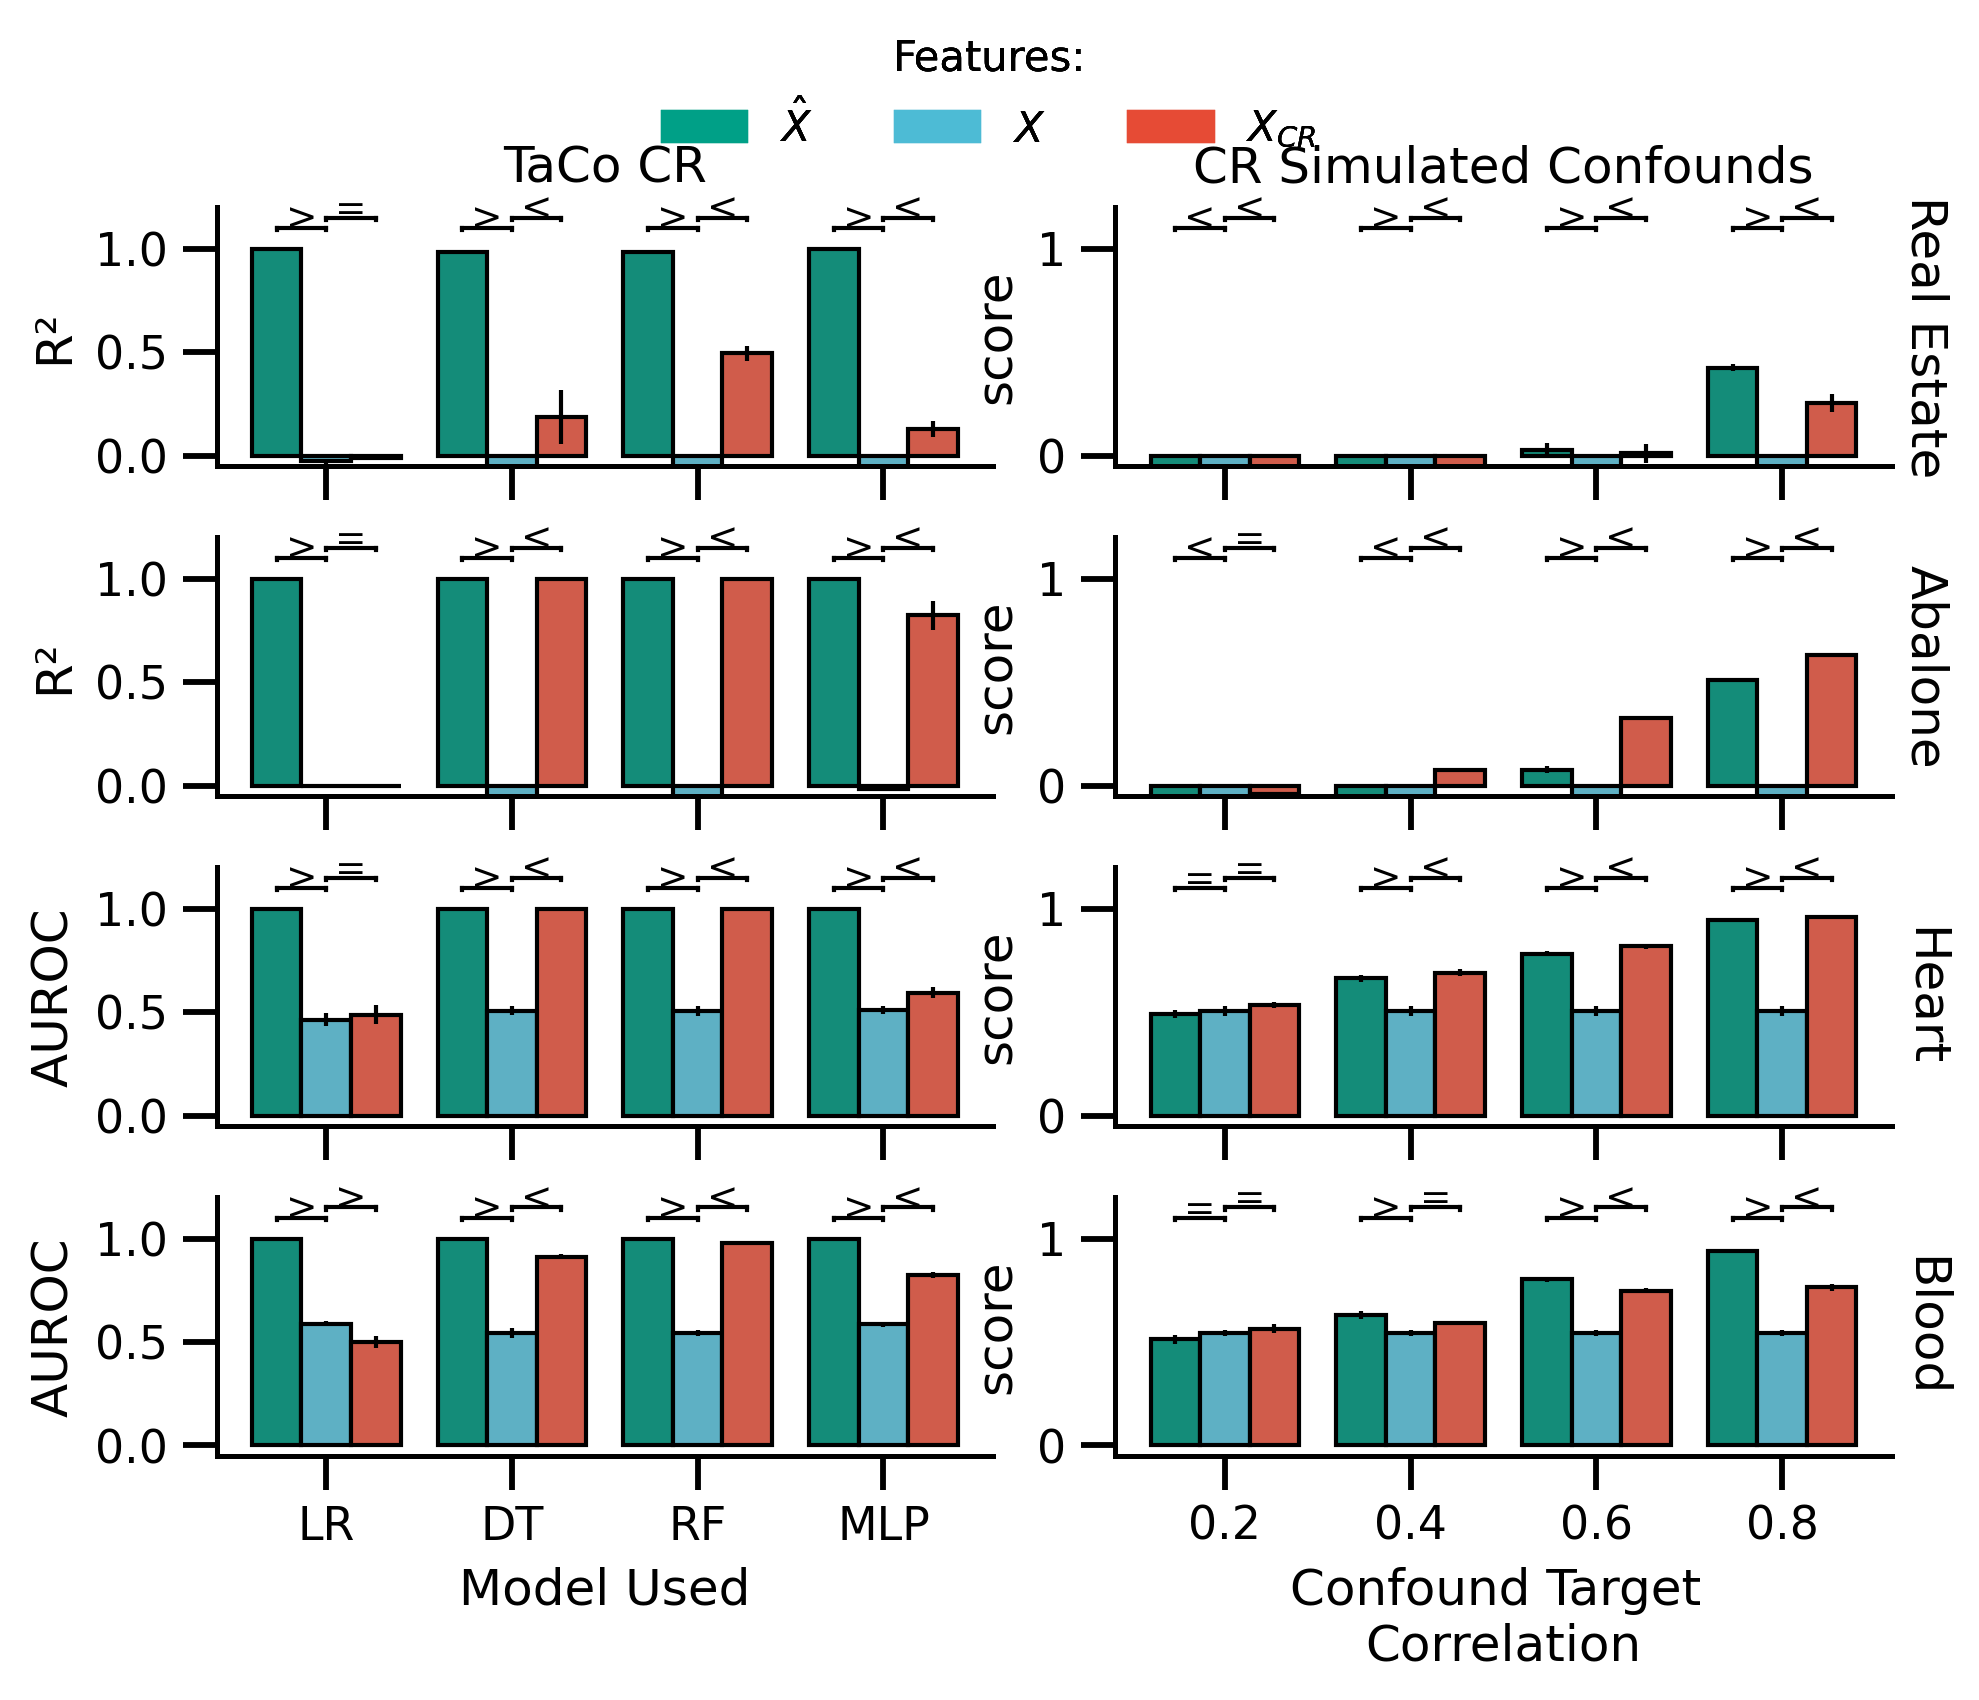

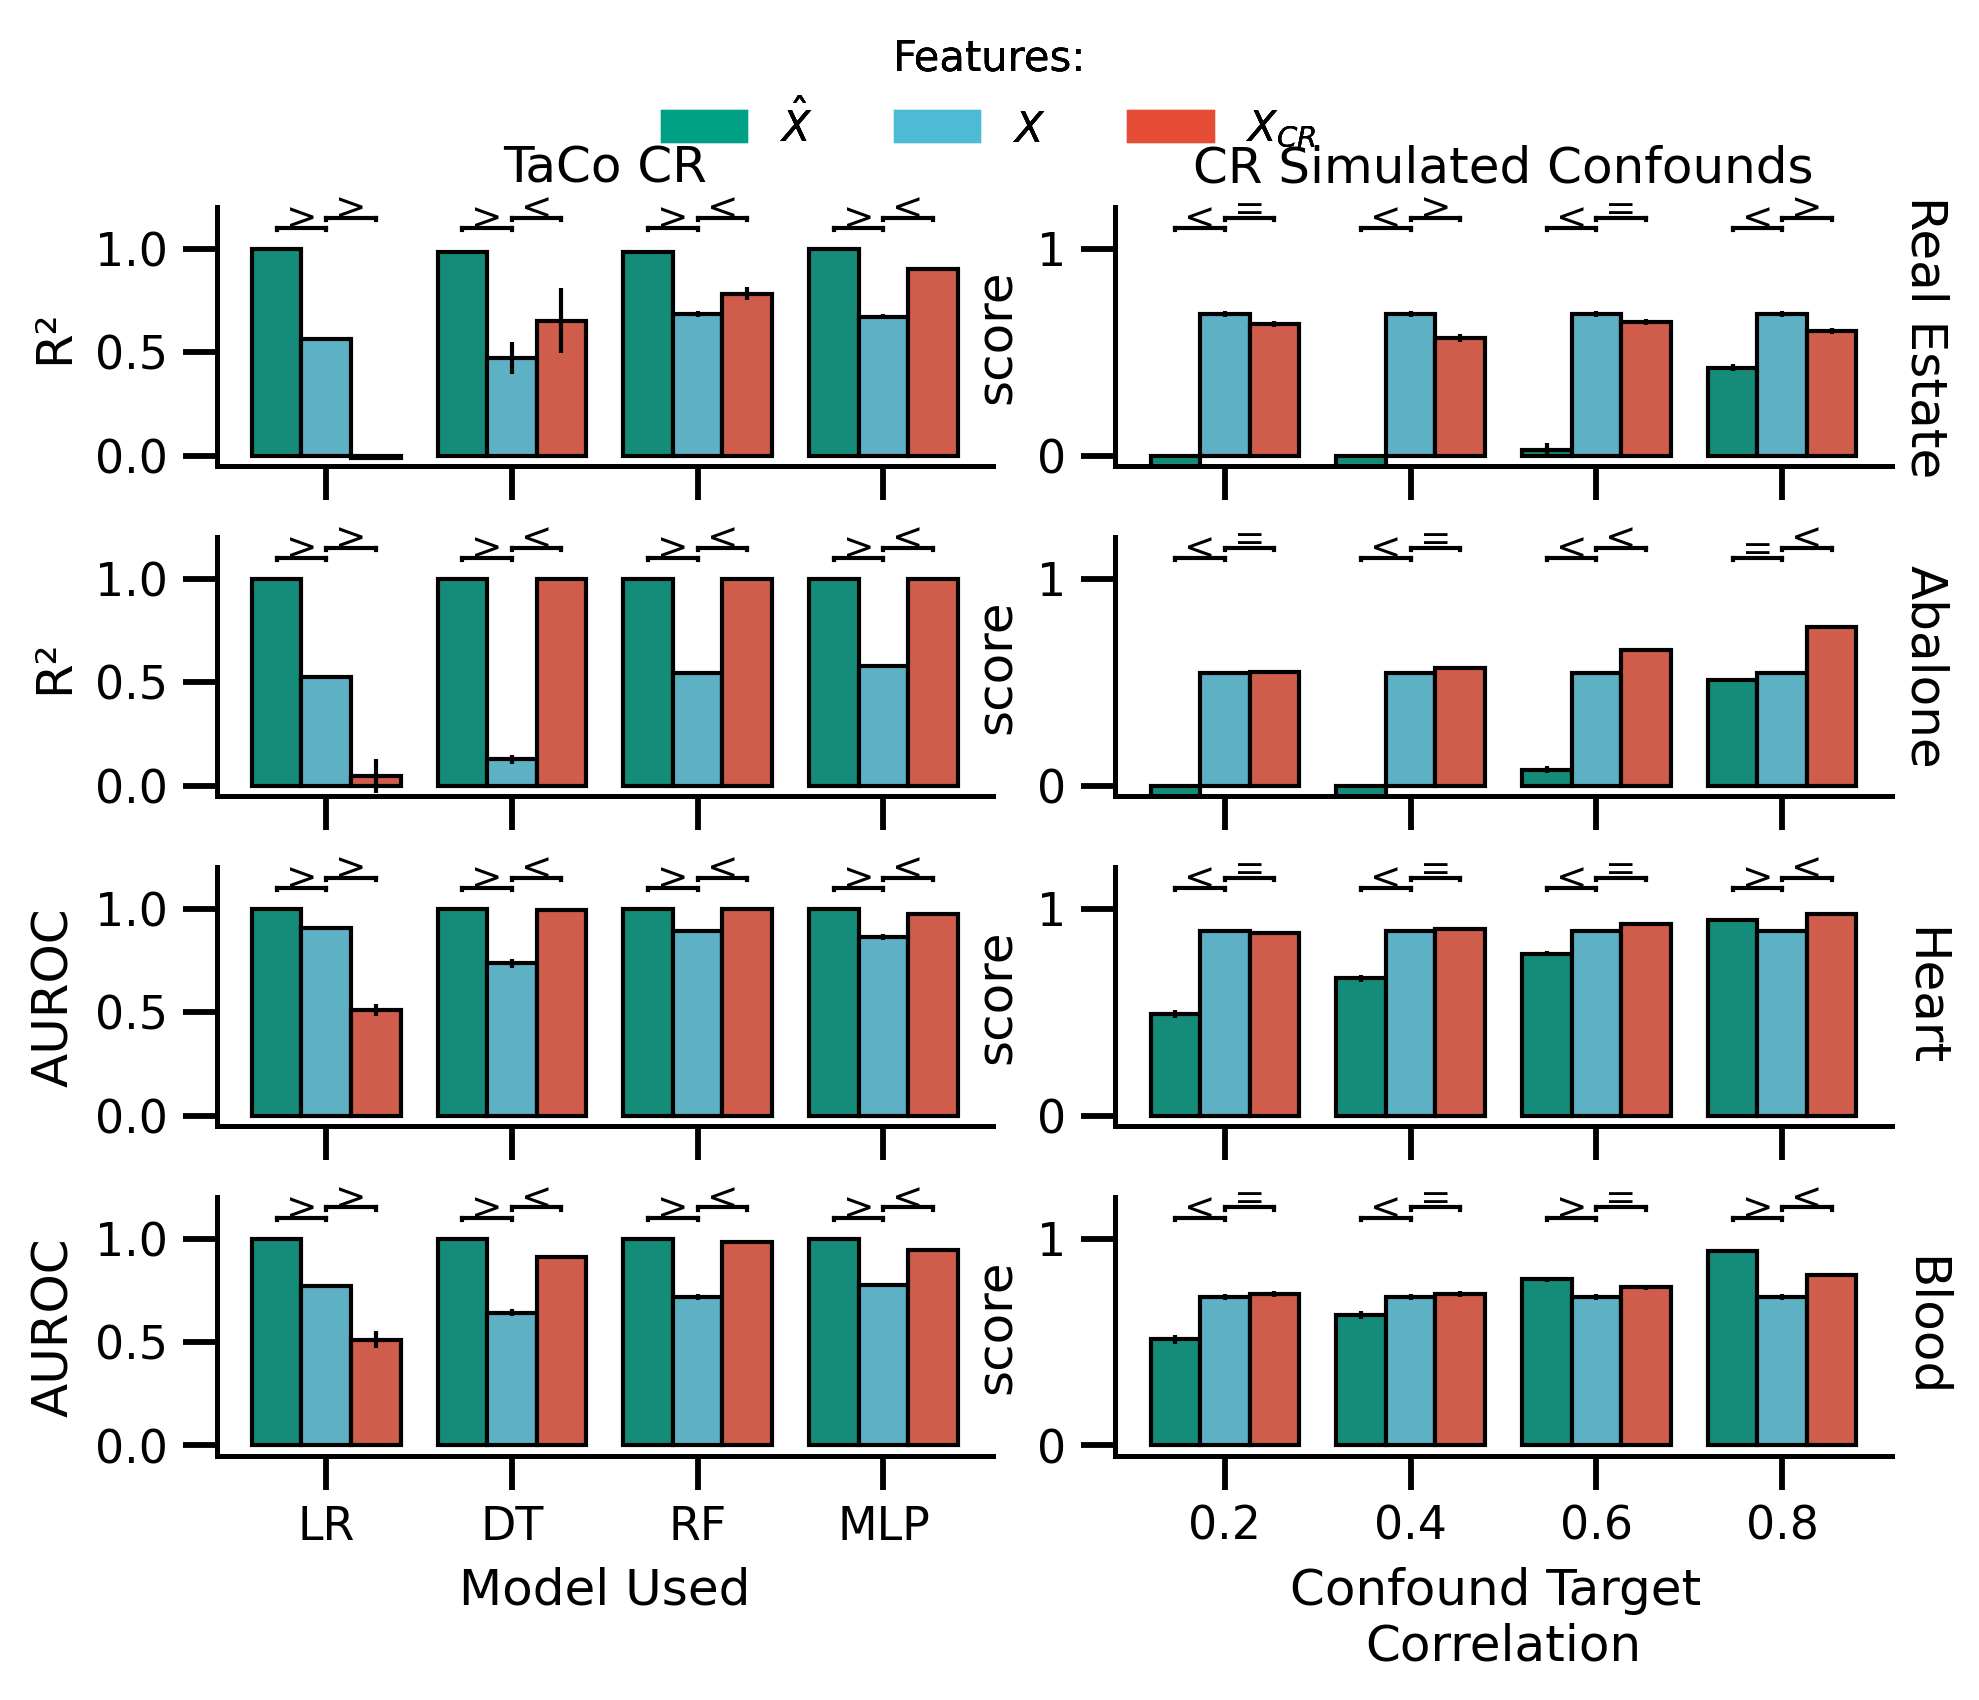

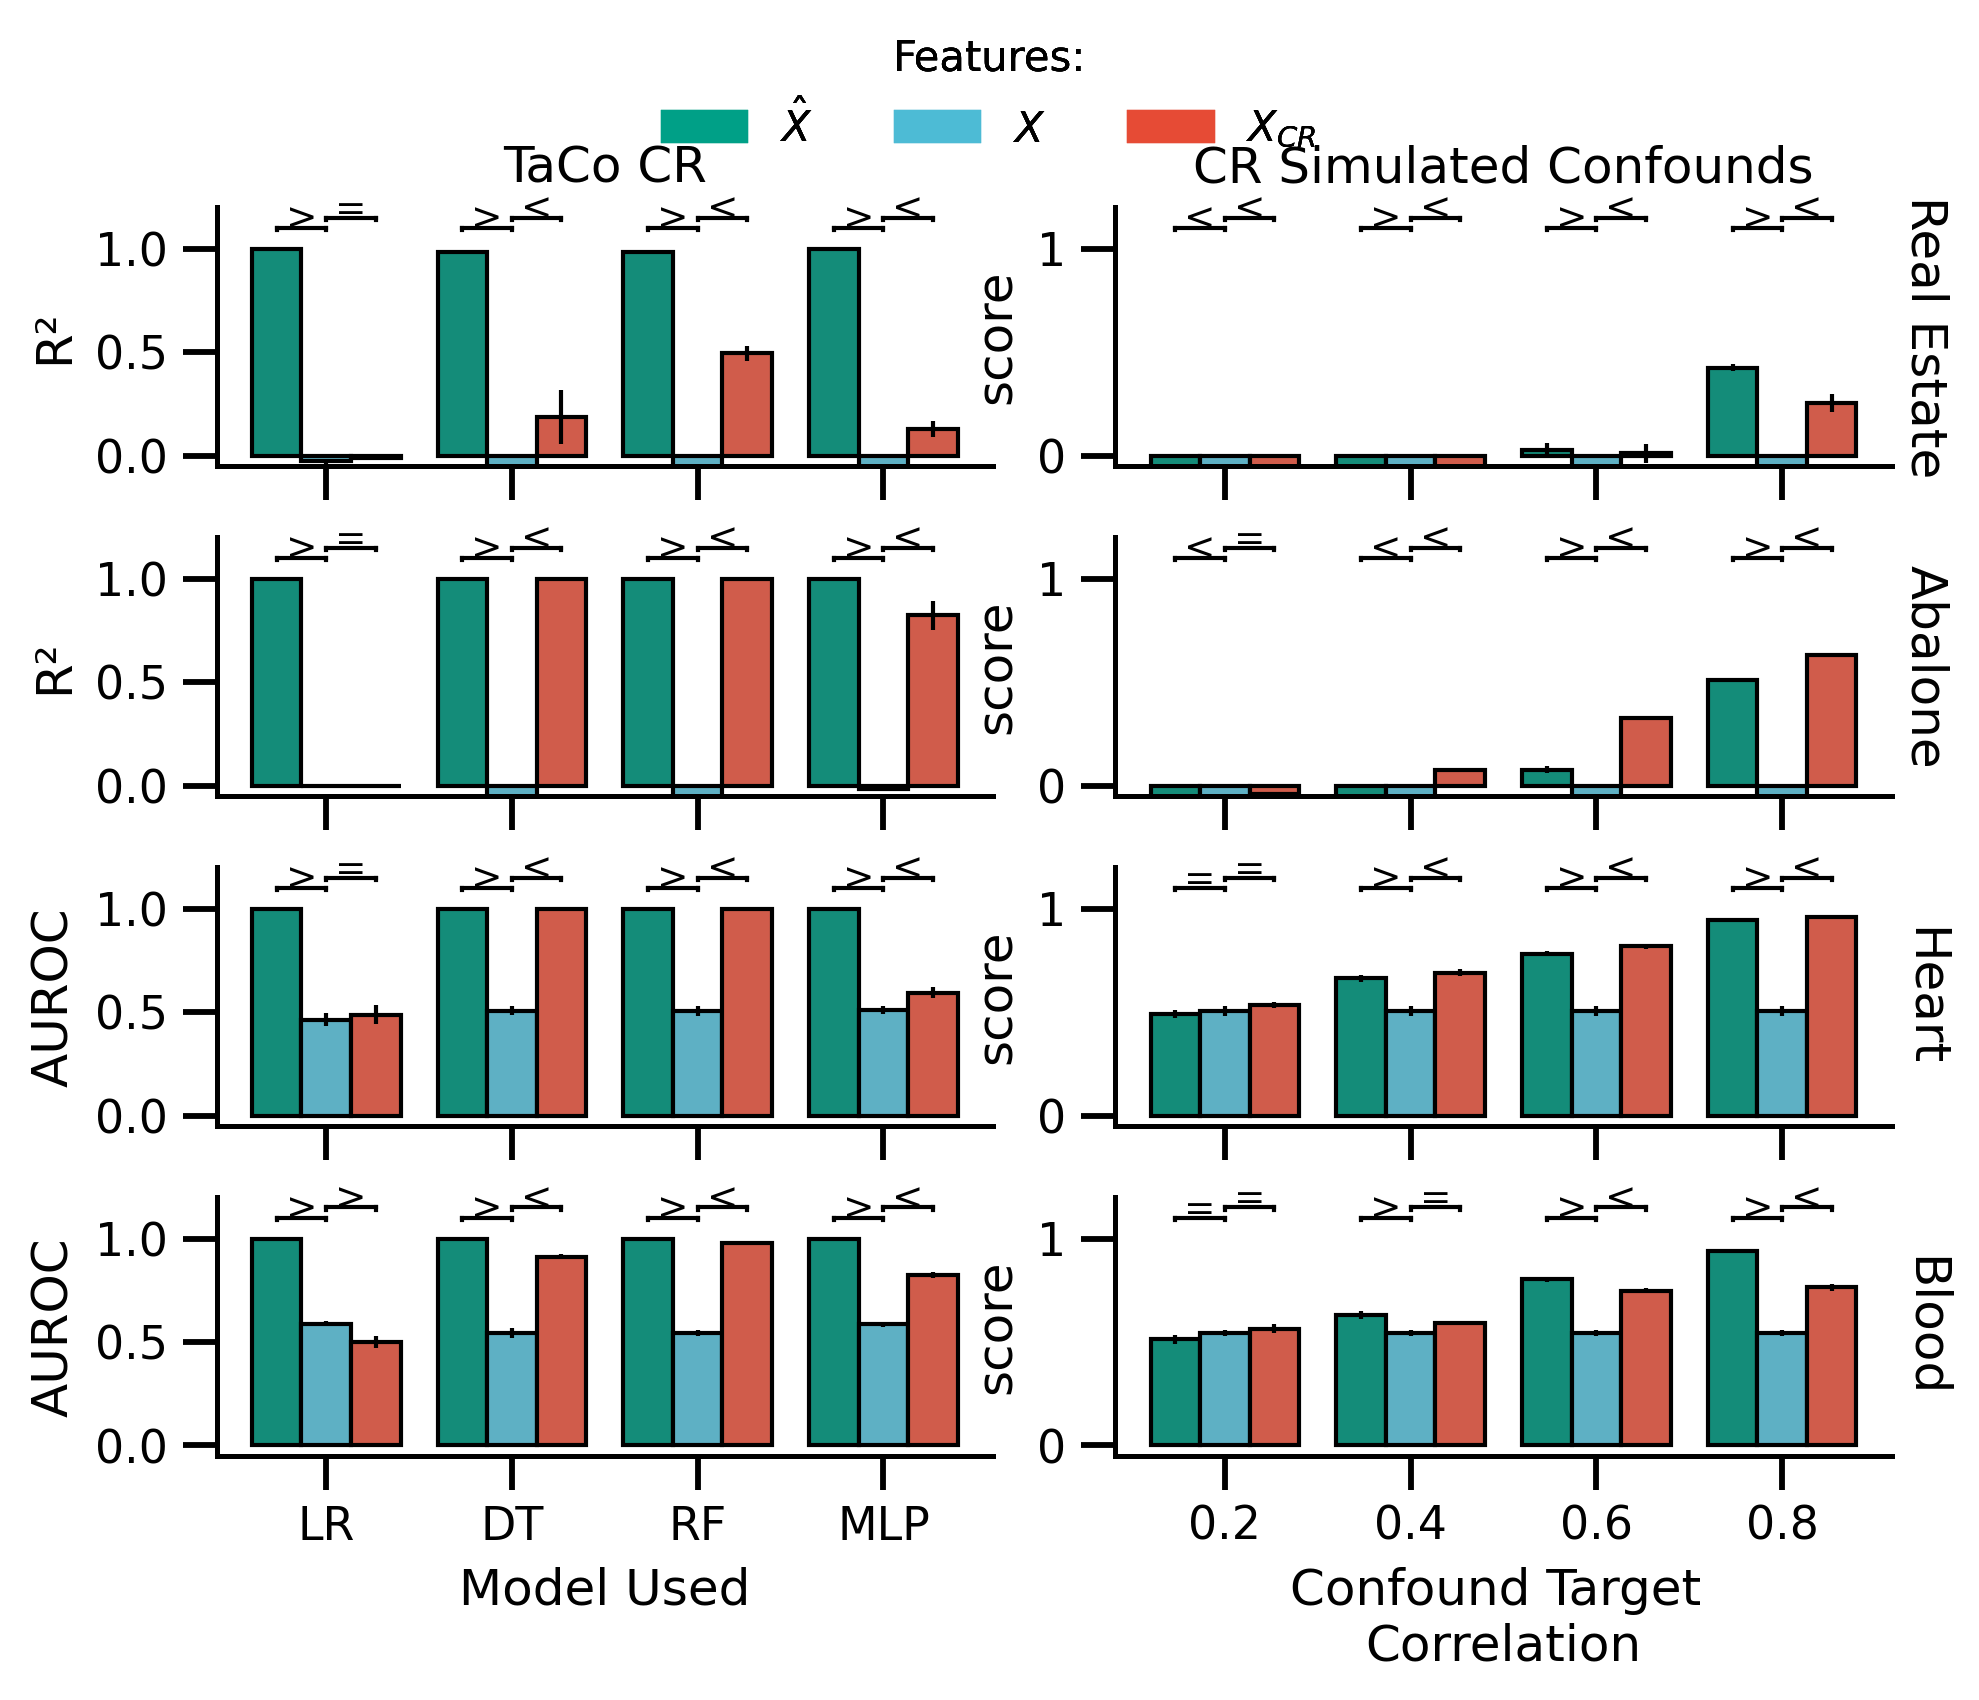

In [9]:

fig_selected, axes = plot_performance(
    df_plot_TaCo_selected,
    df_plot_non_TaCo_selected,
    hue_order=["X hat", "not removed", "removed"],
    figsize=[mm_to_inch(183),
             mm_to_inch(140)])


fig_selected.savefig('./saved_figures/uci_performance.svg')
fig_selected.savefig('./saved_figures/uci_performance.png')

glue("uci_selected", fig_selected, display=False)

fig_shuffled_selected, axes = plot_performance(
    df_plot_TaCo_shuffled_selected,
    df_plot_non_TaCo_shuffled_selected,
    hue_order=["X hat", "not removed", "removed"],
    figsize=[mm_to_inch(183),
             mm_to_inch(140)])


fig_shuffled_selected.savefig('./saved_figures/uci_performance_shuffled.svg')
fig_shuffled_selected.savefig('./saved_figures/uci_performance_shuffled.png')

glue("uci_selected_shuffled", fig_shuffled_selected, display=False)


# Plotting Performance for All Datapoints

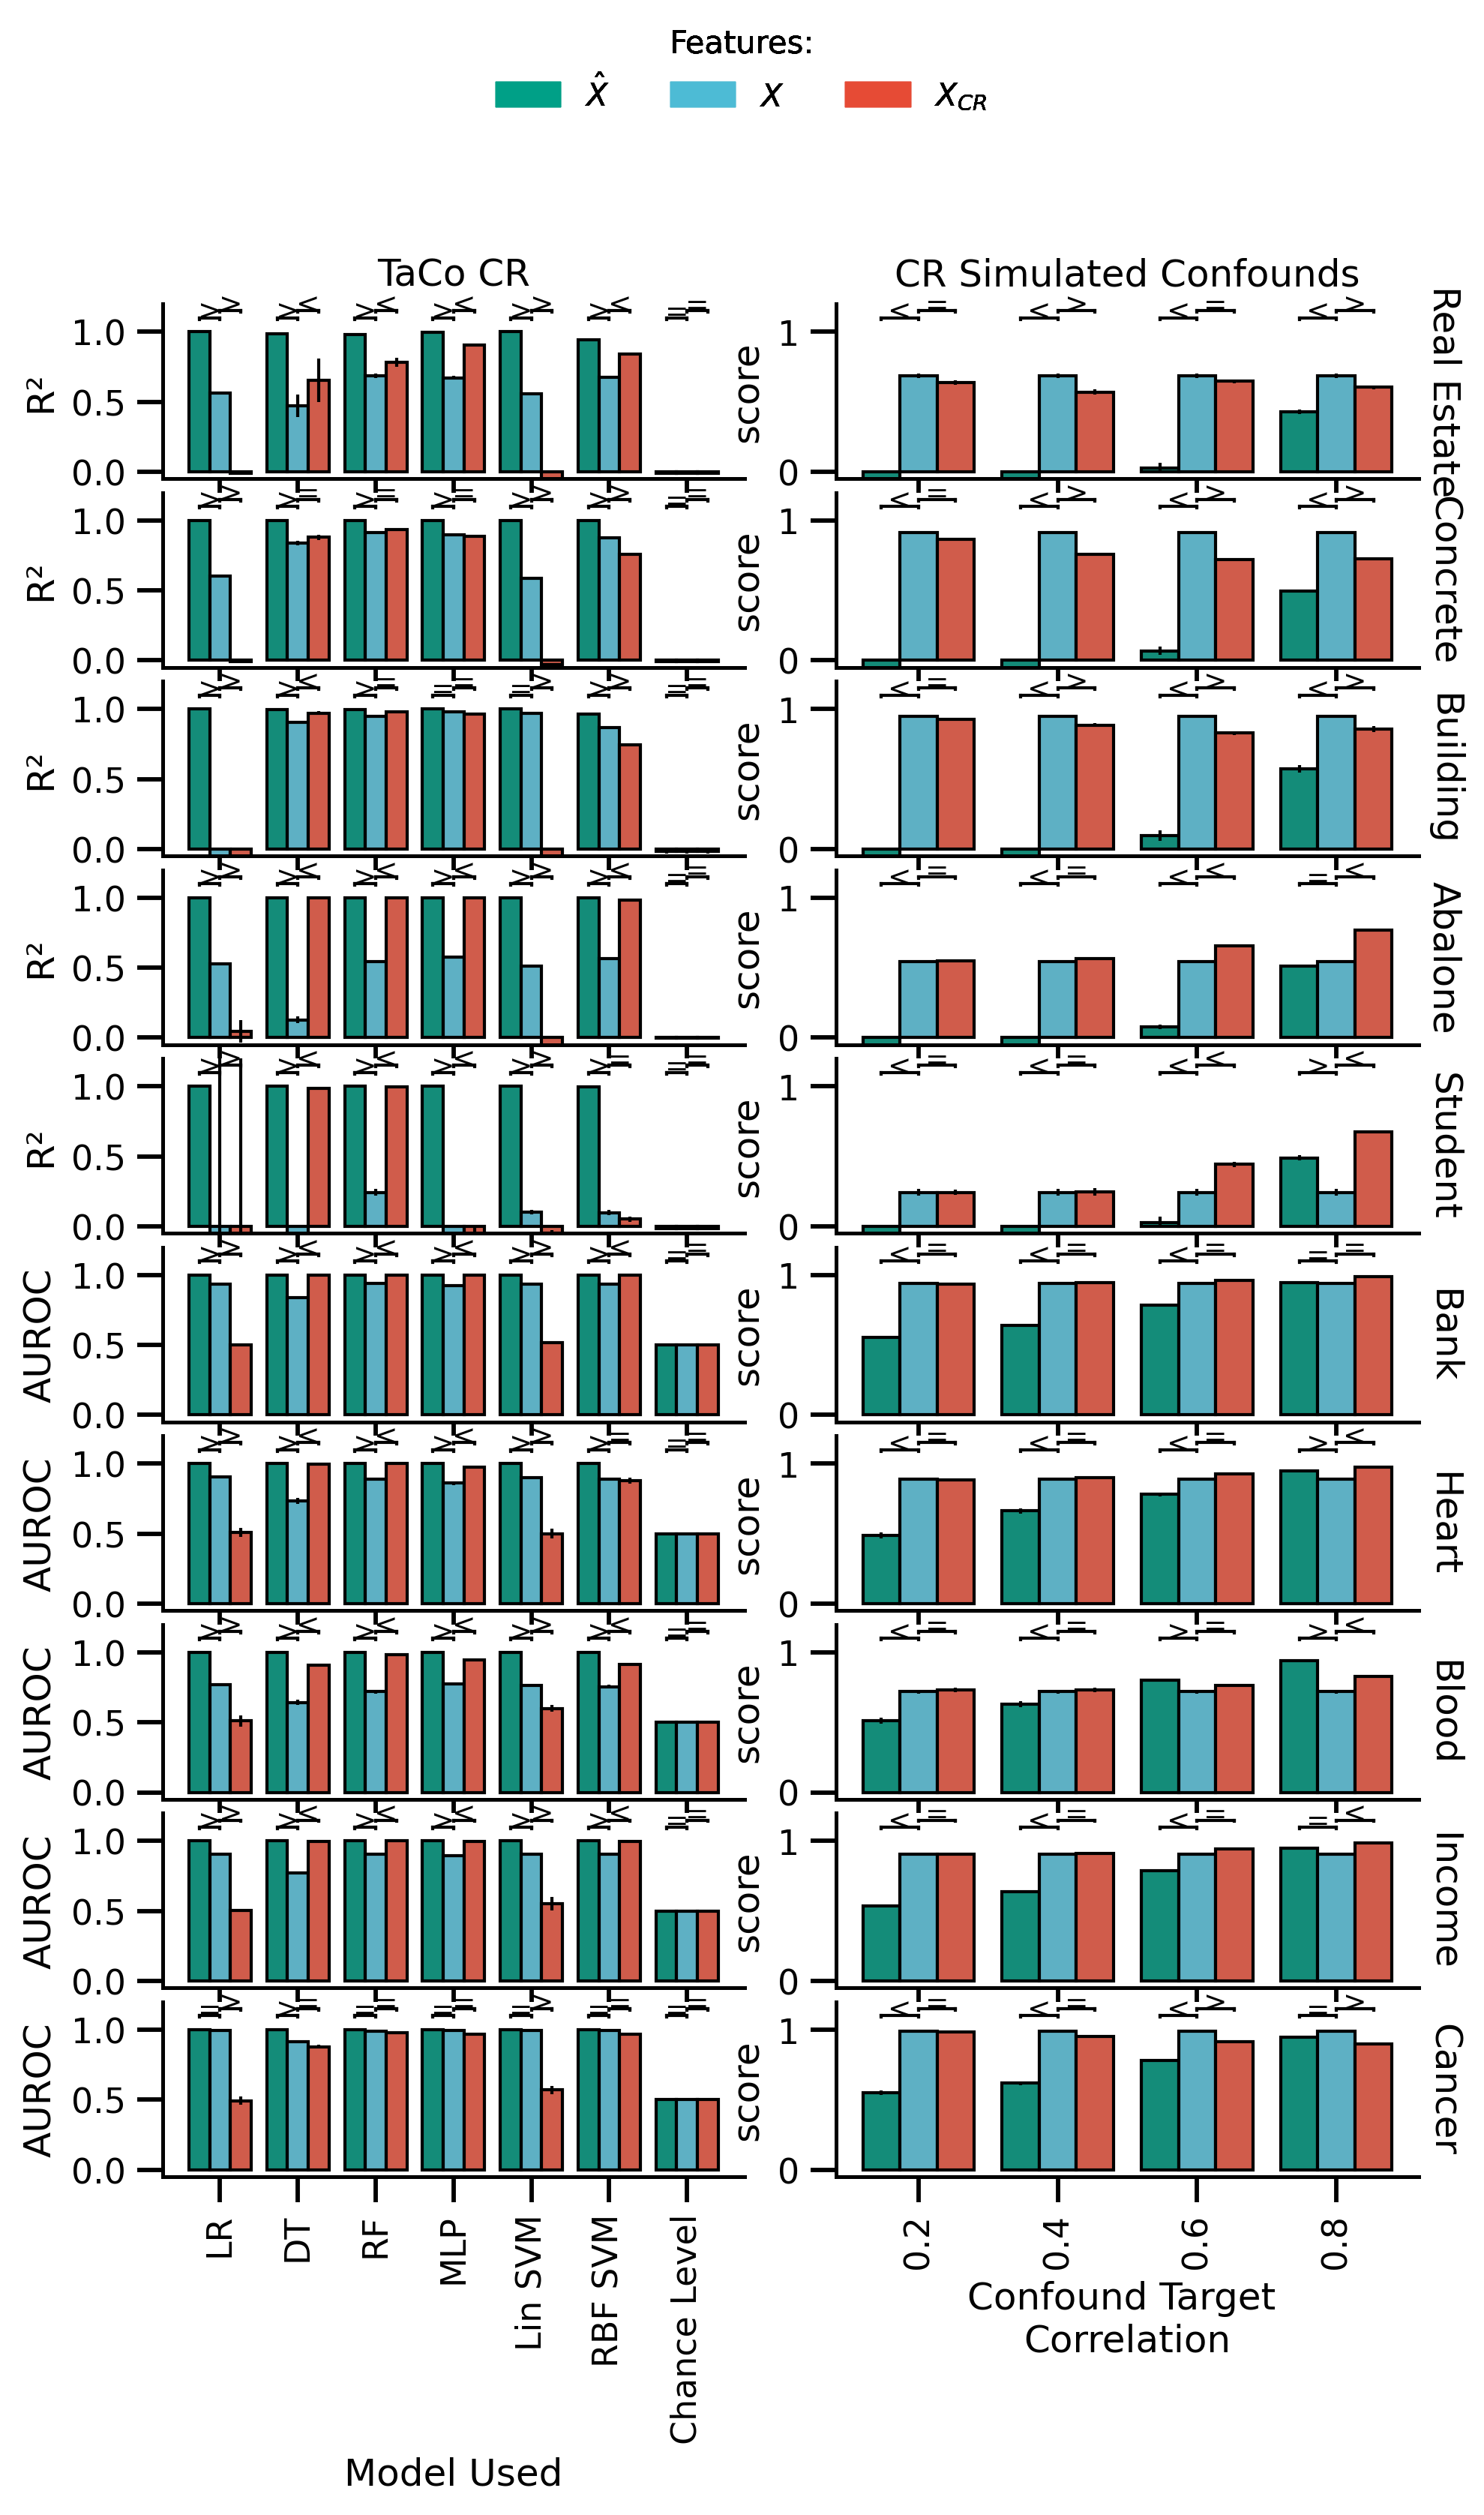

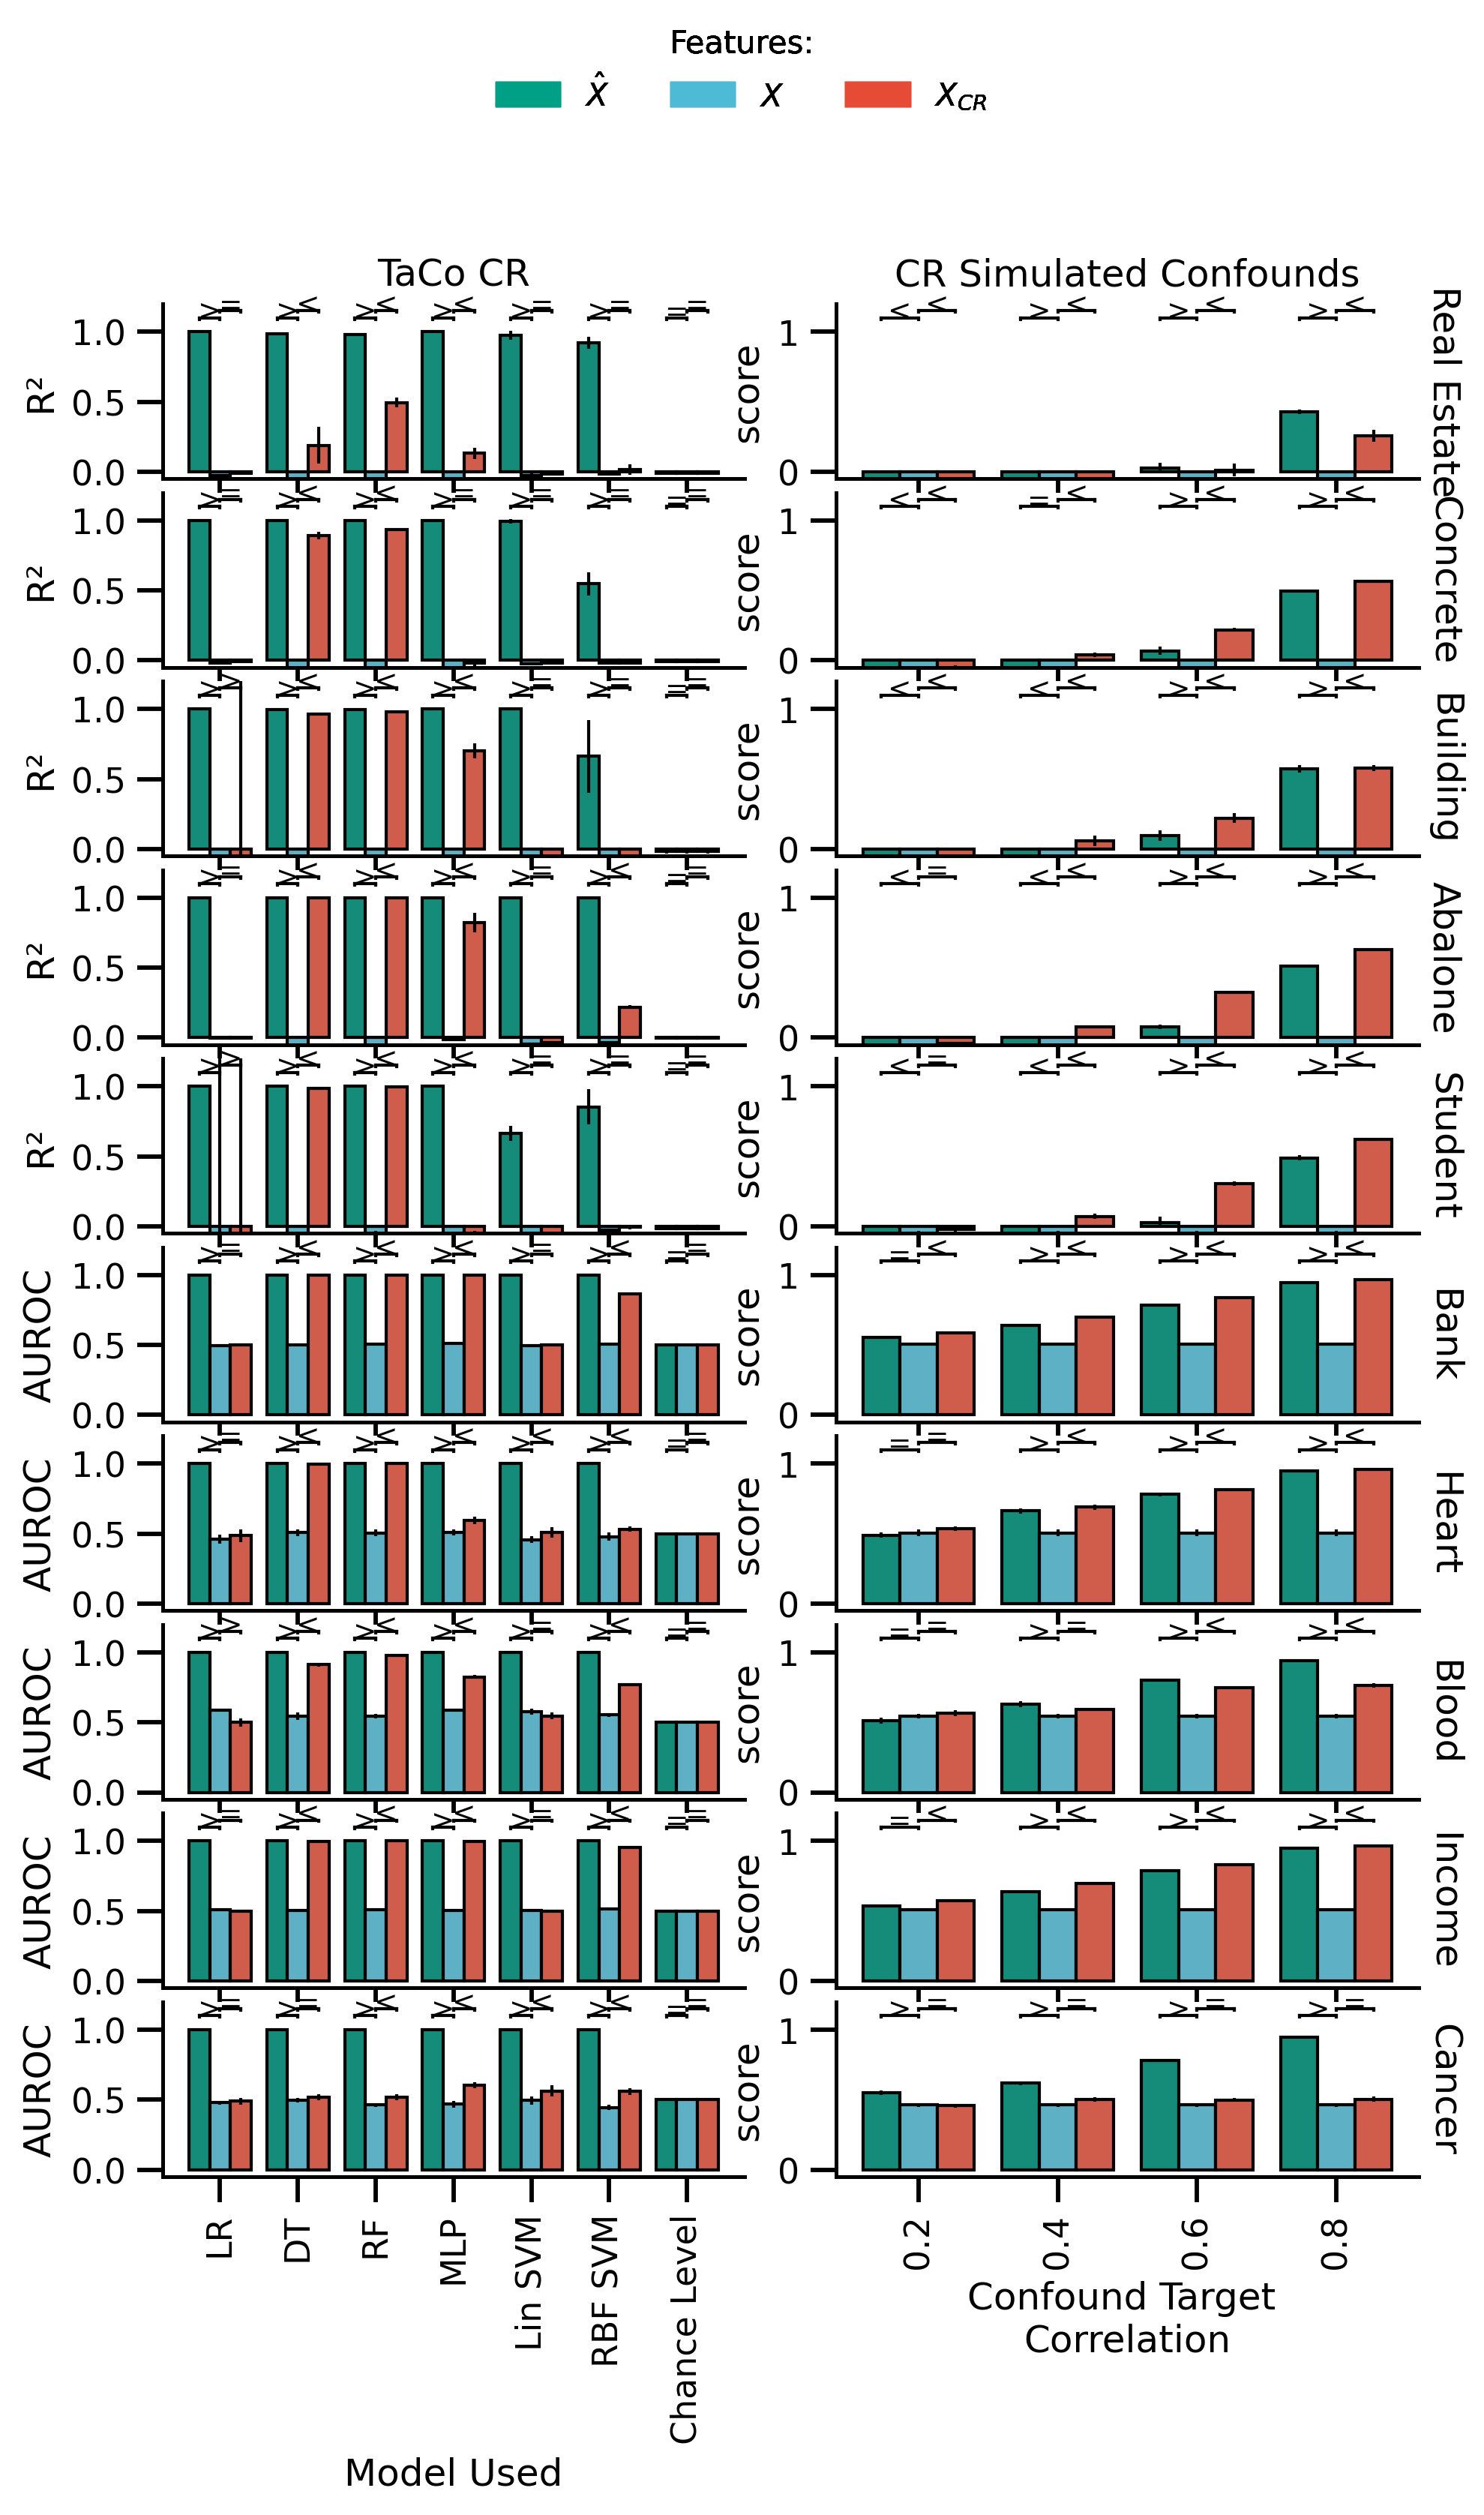

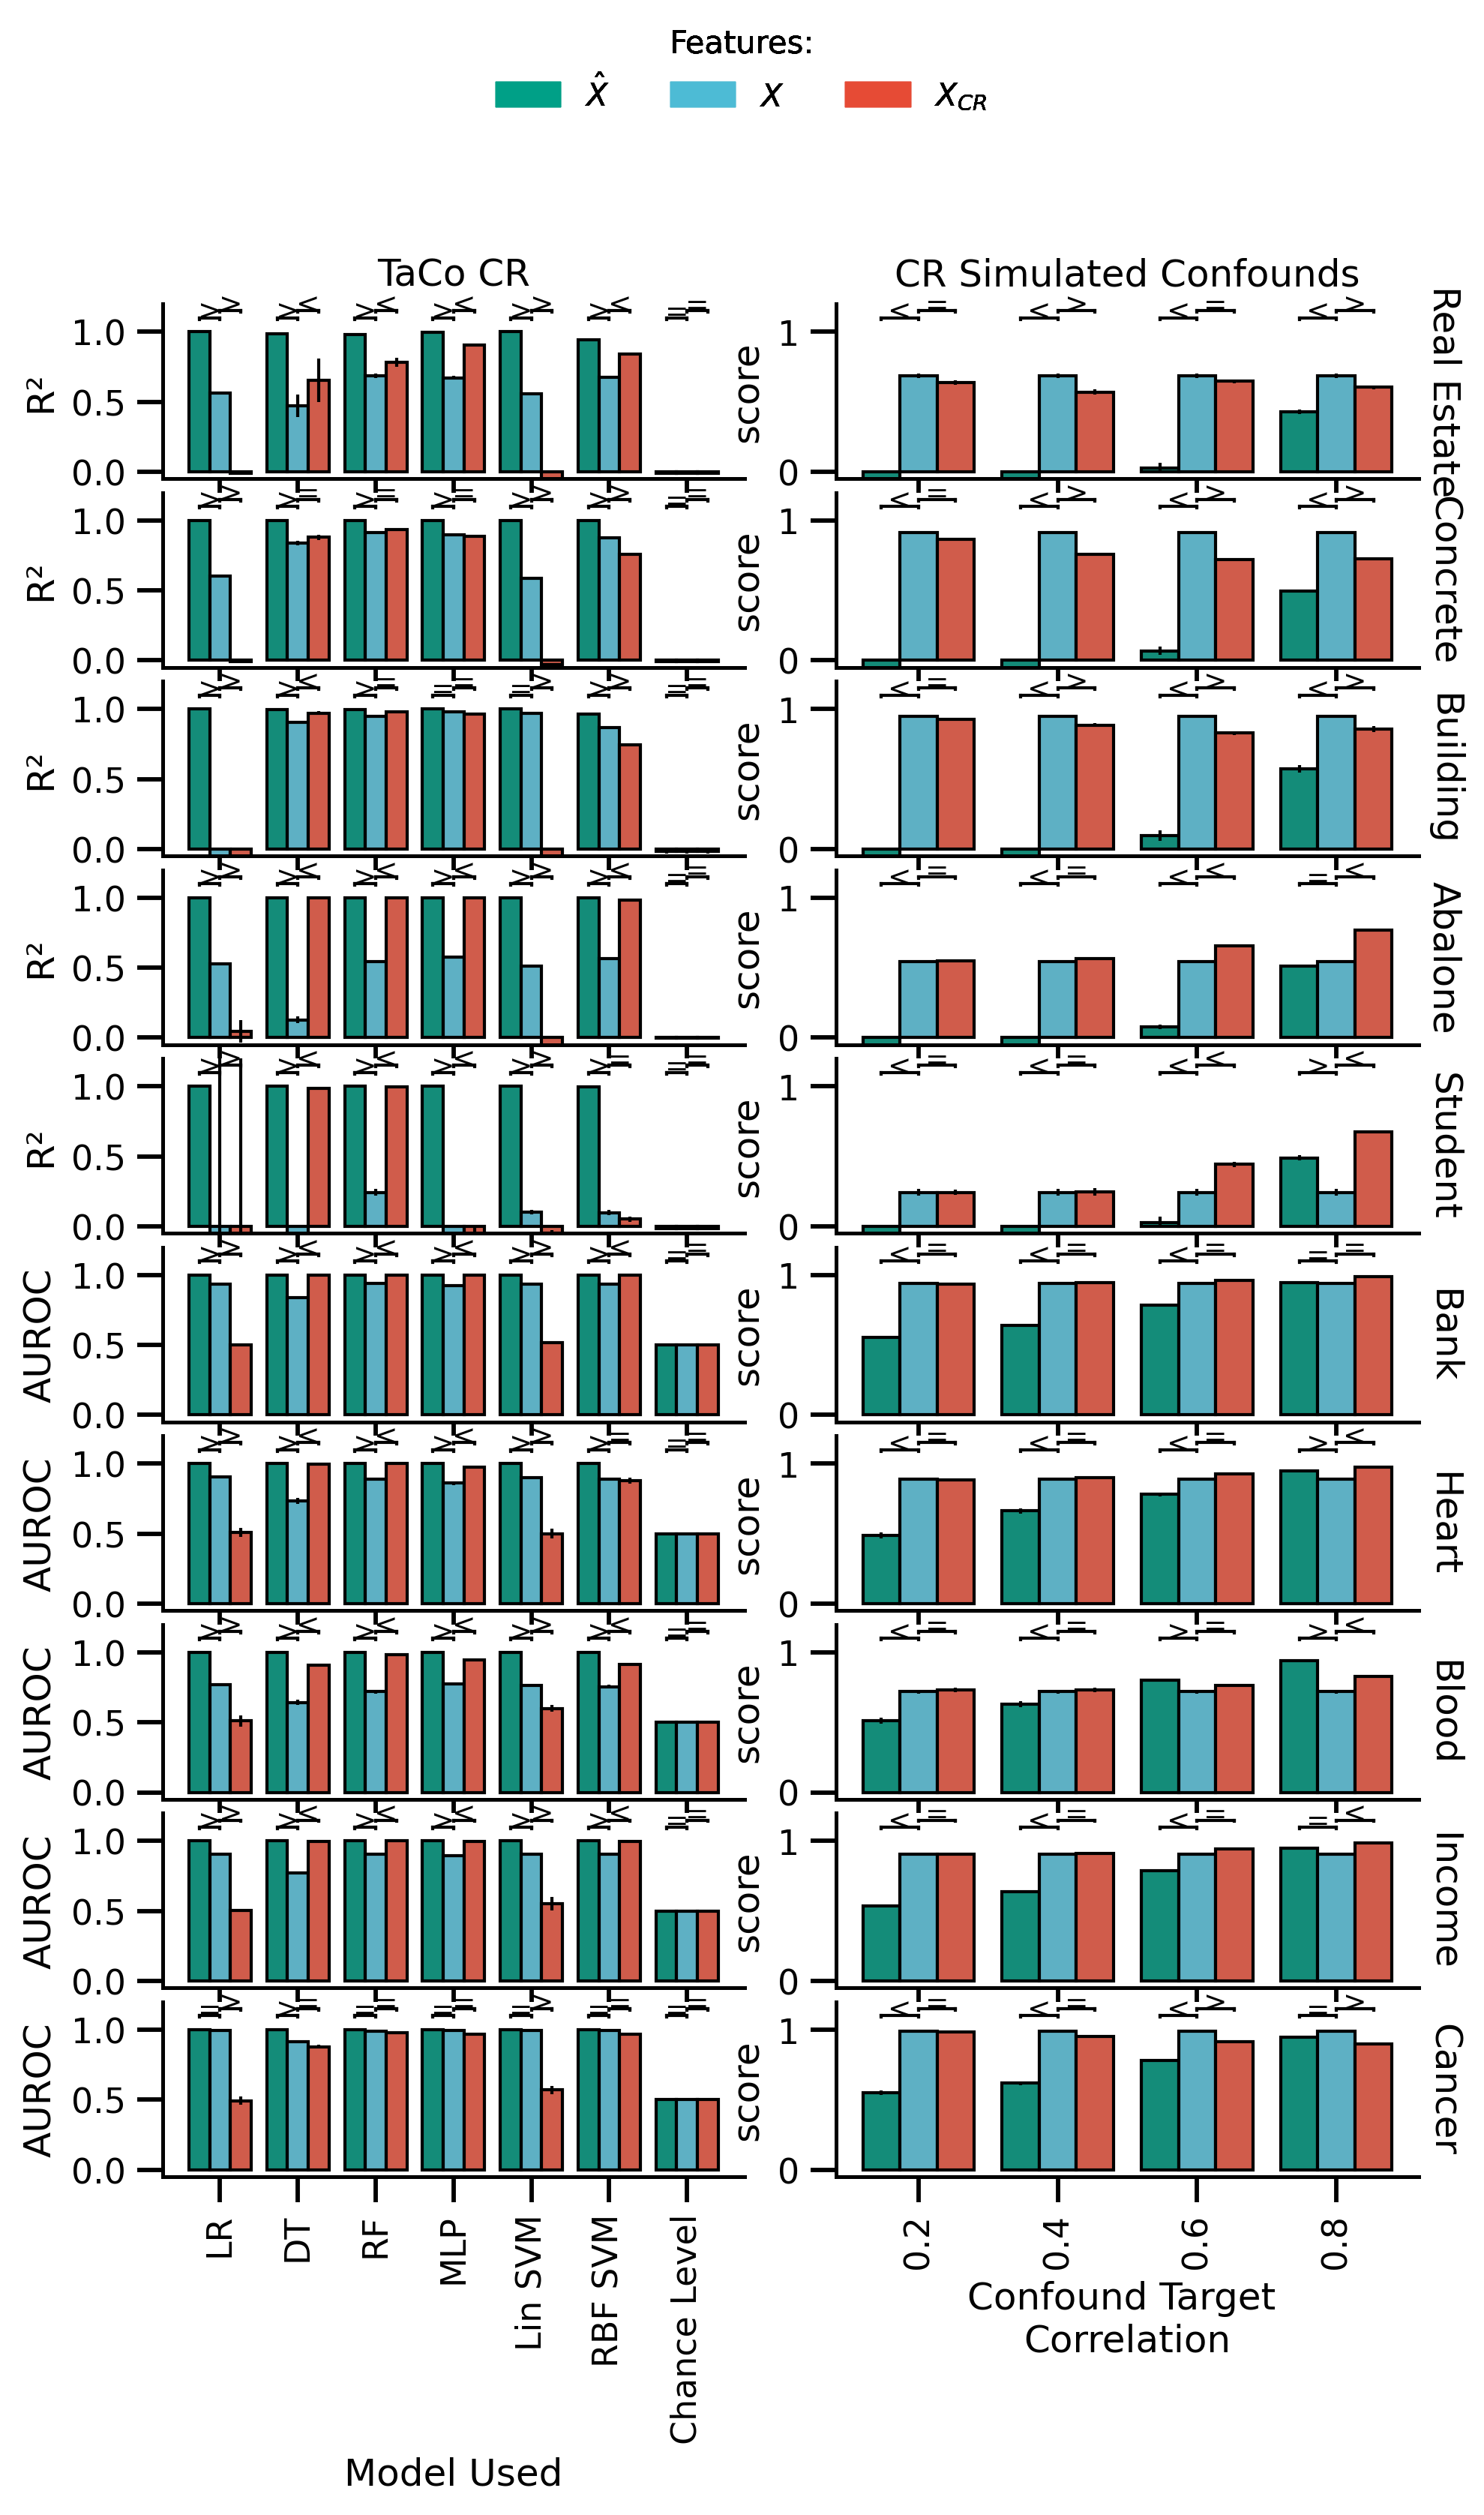

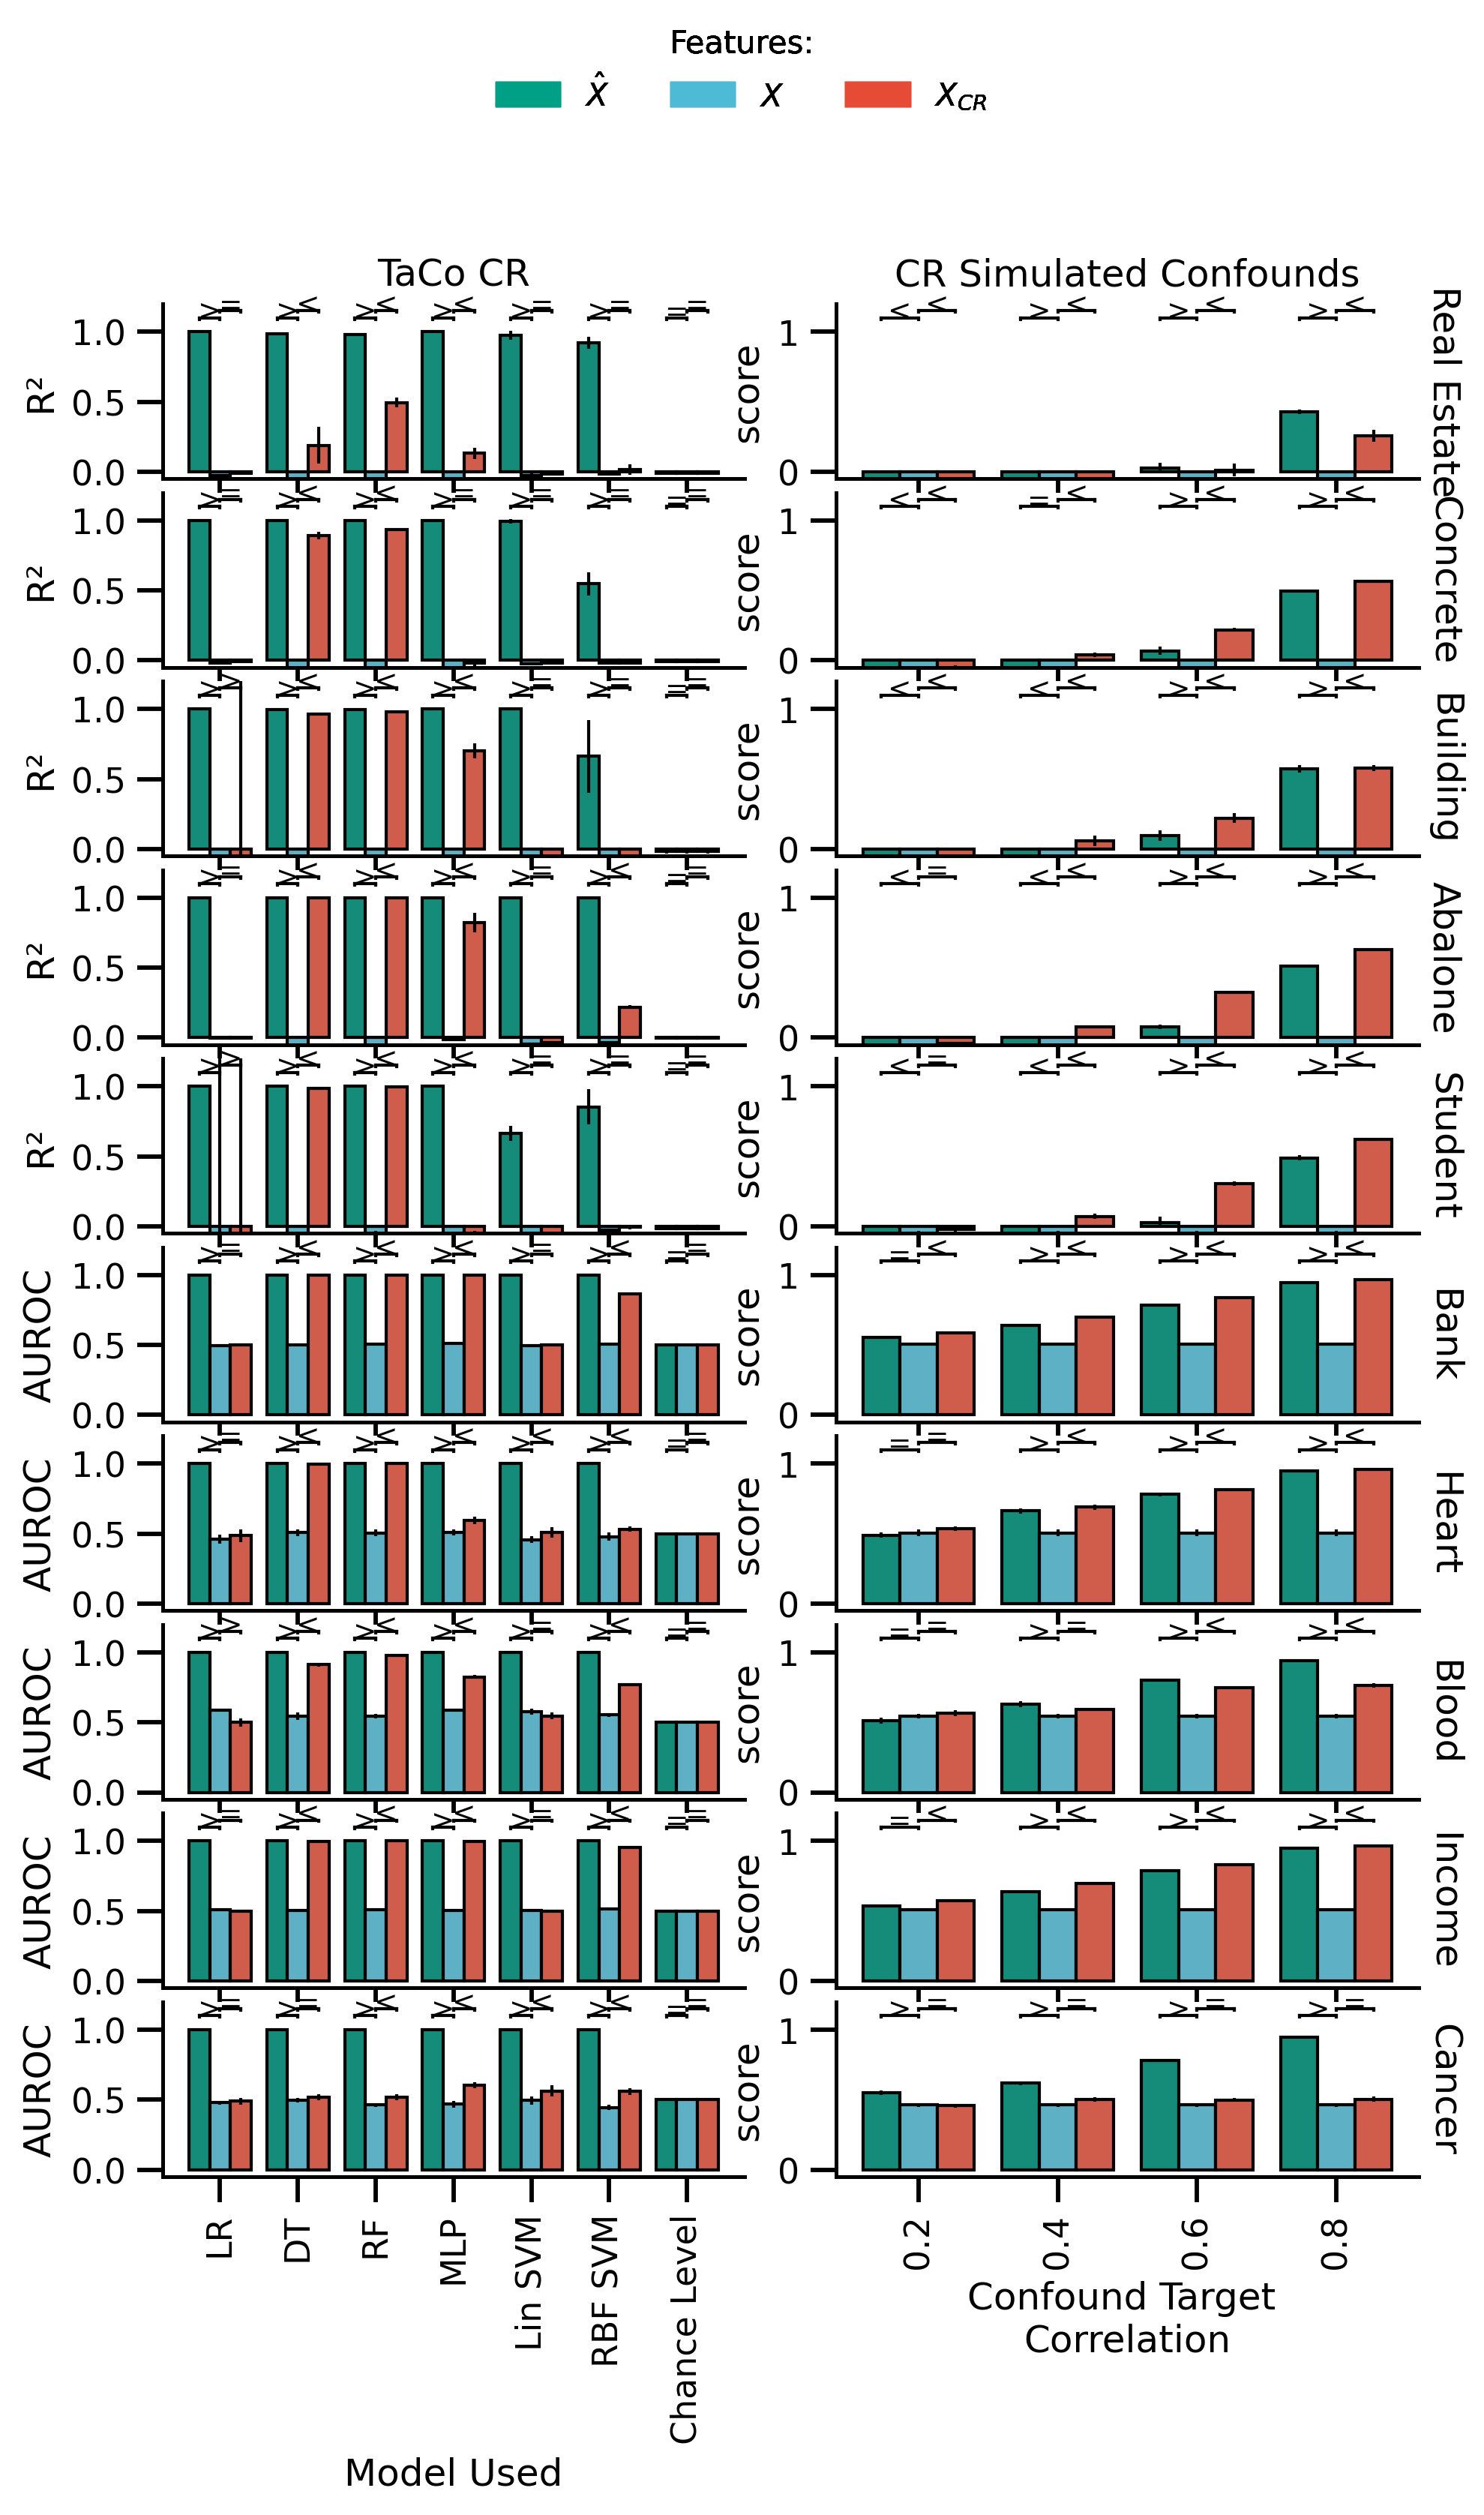

In [10]:
all_model_dict = {
    'Linear/Logistic': 'LR',
    'Decision Tree': 'DT',
    'Random Forest': 'RF',
    'Neural Network': 'MLP',
    'Linear SVM': 'Lin SVM',
    'RBF SVM': 'RBF SVM',
    'Baseline Model': 'Chance Level',


}
with mpl.rc_context({
    'figure.subplot.wspace': mm_to_inch(4),
    'figure.subplot.hspace': mm_to_inch(2)
}):
    fig_all, axes = plot_performance(
        df_plot_TaCo,
        df_plot_non_TaCo,
        figsize=[mm_to_inch(183),
                 mm_to_inch(280)],
        model_label_dict=all_model_dict,
        hue_order=["X hat", "not removed", "removed"],

    )
    axes[-1, 0].set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=90)
    axes[-1, 1].set_xticklabels(axes[-1, 1].get_xticklabels(), rotation=90)

glue("uci_all", fig_all, display=False)

fig_all.savefig('./saved_figures/uci_performance_all.svg')
fig_all.savefig('./saved_figures/uci_performance_all.png')

with mpl.rc_context({
    'figure.subplot.wspace': mm_to_inch(4),
    'figure.subplot.hspace': mm_to_inch(2)
}):
    fig_all_shuffled, axes = plot_performance(
        df_plot_TaCo_shuffled,
        df_plot_non_TaCo_shuffled,
        figsize=[mm_to_inch(183),
                 mm_to_inch(280)],
        model_label_dict=all_model_dict,
        hue_order=["X hat", "not removed", "removed"],

    )
    axes[-1, 0].set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=90)
    axes[-1, 1].set_xticklabels(axes[-1, 1].get_xticklabels(), rotation=90)

glue("uci_all_shuffled", fig_all_shuffled, display=False)
fig_all_shuffled.savefig('./saved_figures/uci_performance_all_shuffled.svg')
fig_all_shuffled.savefig('./saved_figures/uci_performance_all_shuffled.png')

## These are the Figures


````{tabbed}  selected 
```{glue:figure} uci_selected
:figwidth: 900px
```

````

````{tabbed}  selected shuffled 
```{glue:figure} uci_selected_shuffled
:figwidth: 900px
```

````

````{tabbed}  all 
```{glue:figure} uci_all
:figwidth: 900px
```


````

````{tabbed}  all shuffled 
```{glue:figure} uci_all_shuffled
:figwidth: 900px
```
````